In [1]:
%config InlineBackend.figure_format='retina'
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;sns.set_style('whitegrid',{'grid.color':'0.95'})
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats as stats

from sklearn.metrics import confusion_matrix
from tabulate import tabulate 
from statsmodels.formula.api import probit
from statsmodels.formula.api import logit
from linearmodels.iv.model import IV2SLS
from statsmodels.discrete.conditional_models import ConditionalLogit
from statsmodels.discrete.conditional_models import ConditionalMNLogit
from statsmodels.miscmodels.ordinal_model import OrderedModel
from IPython.display import display, Markdown, Latex
from py4etrics import tobit,heckit
from py4etrics.base_for_models import *

In [2]:
url='http://www.principlesofeconometrics.com/poe5/data/csv/'
tran=pd.read_csv(url+'transport.csv')
print(tran.describe(percentiles=[]).transpose())

          count       mean        std   min   50%   max
autotime   21.0  49.347619  32.434914  0.20  51.4  99.1
bustime    21.0  48.123810  34.630823  1.60  38.0  91.5
dtime      21.0  -0.122381   5.691037 -9.07  -0.7   9.1
auto       21.0   0.476190   0.511766  0.00   0.0   1.0


In [3]:
res=smf.ols(formula='auto~dtime', data=tran).fit(cov_type='HC1')
print(res.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4848      0.071      6.809      0.000       0.345       0.624
dtime          0.0703      0.009      8.264      0.000       0.054       0.087


In [4]:
hypo='Intercept+dtime=0'
print(res.t_test(hypo))
tran['phat']=res.predict()
tran['yhat']=0
tran.loc[tran.phat>=0.5, 'yhat']=1

                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.5551      0.070      7.942      0.000       0.418       0.692


In [5]:
cm=confusion_matrix(tran.auto,np.where(tran.phat>=0.5,1,0))
cm=pd.DataFrame(cm,columns=['pred Bus','pred Auto'],index=['actual Bus','actual Auto'])
print('Confusion Matrix for Transportation Linear Probability Model:','\n',cm)

Confusion Matrix for Transportation Linear Probability Model: 
              pred Bus  pred Auto
actual Bus         10          1
actual Auto         1          9


In [6]:
print(tran.loc[(tran.phat<0) | (tran.phat>1)])

    autotime  bustime  dtime  auto      phat  yhat
2        4.1     86.9   8.28     1  1.066961     1
5        0.2     91.2   9.10     1  1.124615     1
7       89.9      2.2  -8.77     0 -0.131823     0
10      99.1      8.4  -9.07     0 -0.152916     0
19      95.1     22.2  -7.29     0 -0.027764     0


In [7]:
y=np.array([1,1,0])
x=np.array([1.5,0.6,0.7])
X=sm.add_constant(x)
resp=sm.Probit(y,X).fit()
print(resp.summary())

Optimization terminated successfully.
         Current function value: 0.531324
         Iterations 6
                          Probit Regression Results                           
Dep. Variable:                      y   No. Observations:                    3
Model:                         Probit   Df Residuals:                        1
Method:                           MLE   Df Model:                            1
Date:                Wed, 18 Jun 2025   Pseudo R-squ.:                  0.1653
Time:                        09:29:21   Log-Likelihood:                -1.5940
converged:                       True   LL-Null:                       -1.9095
Covariance Type:            nonrobust   LLR p-value:                    0.4269
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1525      2.345     -0.491      0.623      -5.749       3.444
x1             1.8916      2.

In [8]:
tran=pd.read_csv(url+'transport.csv')
resp=probit('auto~1+dtime',data=tran).fit()
print(resp.summary())
print(f'LR test statistic (manual):       {-2*(resp.llnull-resp.llf):.4f}')
print(f'LR test statistic (llr property): {resp.llr:.4f}')

Optimization terminated successfully.
         Current function value: 0.293579
         Iterations 6
                          Probit Regression Results                           
Dep. Variable:                   auto   No. Observations:                   21
Model:                         Probit   Df Residuals:                       19
Method:                           MLE   Df Model:                            1
Date:                Wed, 18 Jun 2025   Pseudo R-squ.:                  0.5758
Time:                        09:29:21   Log-Likelihood:                -6.1652
converged:                       True   LL-Null:                       -14.532
Covariance Type:            nonrobust   LLR p-value:                 4.300e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0644      0.399     -0.161      0.872      -0.847       0.718
dtime          0.3000      0.

In [9]:
x=[0,2,3]
print('Linear Prediction: Manual Computation')
for i in x:
    y_pred=resp.params.iloc[0]+resp.params.iloc[1]*i
    print(f'y_hat when DTIME = {str(i)} : {y_pred:.5f}')
    i=+1

Linear Prediction: Manual Computation
y_hat when DTIME = 0 : -0.06443
y_hat when DTIME = 2 : 0.53555
y_hat when DTIME = 3 : 0.83554


In [10]:
x=[0,2,3]
print('Predicted Probability: Manual Computation')
for i in x:
    y_pred=resp.params.iloc[0]+resp.params.iloc[1]*i
    p_hatm=stats.norm.cdf(y_pred)
    print(f'p_hat when DTIME = {str(i)} : {p_hatm:.5f}')
    i=+1

Predicted Probability: Manual Computation
p_hat when DTIME = 0 : 0.47431
p_hat when DTIME = 2 : 0.70386
p_hat when DTIME = 3 : 0.79829


In [11]:
p_hatc=resp.predict(exog=dict(dtime=x))
print('Predicted Probability: "Predict" Command')
print(f'p_hat when DTIME = {str(i)} : {p_hatc[0]:.5f}')
print(f'p_hat when DTIME = {str(i)} : {p_hatc[1]:.5f}')
print(f'p_hat when DTIME = {str(i)} : {p_hatc[2]:.5f}')

Predicted Probability: "Predict" Command
p_hat when DTIME = 1 : 0.47431
p_hat when DTIME = 1 : 0.70386
p_hat when DTIME = 1 : 0.79829


In [12]:
print('Marginal Effect: Manual Computation')
for i in x:
    y_pred=resp.params.iloc[0]+resp.params.iloc[1]*i
    marg_eff=stats.norm.pdf(y_pred)*resp.params.iloc[1]
    print(f'dy/dx when DTIME = {str(i)} : {marg_eff:.5f}')

Marginal Effect: Manual Computation
dy/dx when DTIME = 0 : 0.11943
dy/dx when DTIME = 2 : 0.10369
dy/dx when DTIME = 3 : 0.08442


In [13]:
mer=resp.get_margeff(atexog={1:2})
print(mer.summary())

       Probit Marginal Effects       
Dep. Variable:                   auto
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dtime          0.1037      0.033      3.177      0.001       0.040       0.168


In [14]:
mem=resp.get_margeff(atexog={1:tran.dtime.mean()})
print(mem.summary())

       Probit Marginal Effects       
Dep. Variable:                   auto
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dtime          0.1191      0.041      2.904      0.004       0.039       0.199


In [15]:
y_pred_mean=resp.params.iloc[0]+resp.params.iloc[1]*tran.dtime
ame=stats.norm.pdf(y_pred_mean)*resp.params.iloc[1]
print('Summary Statistics for AME')
print(f'count     mean     sd     min     max')
print(f' {resp.nobs}      {ame.mean():.4f}  {ame.std():.4f} \
{ame.min():.4f}  {ame.max():.4f}')

Summary Statistics for AME
count     mean     sd     min     max
 21      0.0484  0.0356 0.0025  0.1153


In [16]:
cov=resp.cov_params()
print(f'Variance-Covariance Matrix \n {np.round(cov,4)}')

Variance-Covariance Matrix 
            Intercept   dtime
Intercept     0.1594  0.0003
dtime         0.0003  0.0106


In [17]:
cov_np=cov.to_numpy()
print(f'NumPy Variance-Covariance Matrix \n {np.round(cov_np,4)}')

NumPy Variance-Covariance Matrix 
 [[0.1594 0.0003]
 [0.0003 0.0106]]


In [18]:
cov_np00=cov_np[0,0]
cov_np01=cov_np[0,1]
cov_np11=cov_np[1,1]
y_pred2=resp.params.iloc[0]+resp.params.iloc[1]*2
p_beta0=-stats.norm.pdf(y_pred2)*y_pred2*resp.params.iloc[1]
print(f'predicted dg(b1,b2)/db1 = {p_beta0:.3f}')
p_beta1=stats.norm.pdf(y_pred2)*(1-y_pred2*resp.params.iloc[1]*2)
print(f'predicted dg(b1,b2)/db1 =  {p_beta1:.3f}')

predicted dg(b1,b2)/db1 = -0.056
predicted dg(b1,b2)/db1 =  0.235


In [19]:
var=p_beta0**2*cov_np00+p_beta1**2*cov_np11+2*p_beta0*p_beta1*cov_np01
print(f'predicted var(g(b1,b2)) = {var:.5f}')
print(f'predicted se(g(b1,b2)) =  {var**0.5:.5f}')

predicted var(g(b1,b2)) = 0.00107
predicted se(g(b1,b2)) =  0.03264


In [20]:
coke=pd.read_csv(url+'coke.csv')
print(coke.dtypes)
print(coke.describe())

coke            int64
pr_pepsi      float64
pr_coke       float64
disp_pepsi      int64
disp_coke       int64
pratio        float64
dtype: object
              coke     pr_pepsi      pr_coke   disp_pepsi    disp_coke  \
count  1140.000000  1140.000000  1140.000000  1140.000000  1140.000000   
mean      0.447368     1.202719     1.190088     0.364035     0.378947   
std       0.497440     0.300726     0.299916     0.481370     0.485338   
min       0.000000     0.680000     0.680000     0.000000     0.000000   
25%       0.000000     0.980000     0.890000     0.000000     0.000000   
50%       0.000000     1.190000     1.190000     0.000000     0.000000   
75%       1.000000     1.390000     1.390000     1.000000     1.000000   
max       1.000000     1.790000     1.790000     1.000000     1.000000   

            pratio  
count  1140.000000  
mean      1.027249  
std       0.286608  
min       0.497207  
25%       0.857143  
50%       1.000000  
75%       1.150376  
max       2.324675 

In [21]:
resols=smf.ols('coke~pratio+disp_coke+disp_pepsi',data=coke).fit(cov_type='HC1')
print(resols.summary().tables[1])
coke['phatols']=resols.predict()

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8902      0.065     13.632      0.000       0.762       1.018
pratio        -0.4009      0.060     -6.640      0.000      -0.519      -0.283
disp_coke      0.0772      0.034      2.274      0.023       0.011       0.144
disp_pepsi    -0.1657      0.034     -4.821      0.000      -0.233      -0.098


In [22]:
x=pd.DataFrame({'Intercept':[1],'pratio':[1.1],'disp_coke':[0],'disp_pepsi':[0]})
meols=resols.get_prediction(x).summary_frame()[['mean','mean_se','mean_ci_lower',
                                                'mean_ci_upper']]
print(f'Marginal effect for the Coke Linear Probability Model \n {round(meols,5)}')

Marginal effect for the Coke Linear Probability Model 
       mean  mean_se  mean_ci_lower  mean_ci_upper
0  0.44927   0.0202        0.40967        0.48886


In [23]:
cmols=confusion_matrix(coke.coke,np.where(coke.phatols>=0.5,1,0))
cmols=pd.DataFrame(cmols,columns=['pred Pepsi','pred Coke'],
                   index=['actual Pepsi','actual Coke'])
print(f'Confusion Matrix for the Coke Linear Probability Model \n {cmols}')

Confusion Matrix for the Coke Linear Probability Model 
               pred Pepsi  pred Coke
actual Pepsi         507        123
actual Coke          263        247


In [24]:
resp=probit('coke~pratio+disp_coke+disp_pepsi',data=coke).fit()
print(resp.summary().tables[1])
coke['phatp']=resp.predict()

Optimization terminated successfully.
         Current function value: 0.623639
         Iterations 5
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1081      0.190      5.833      0.000       0.736       1.480
pratio        -1.1460      0.181     -6.335      0.000      -1.500      -0.791
disp_coke      0.2172      0.097      2.248      0.025       0.028       0.407
disp_pepsi    -0.4473      0.101     -4.411      0.000      -0.646      -0.249


In [25]:
x=pd.DataFrame({'Intercept':[1],'pratio':[1.1],'disp_coke':[0],'disp_pepsi':[0]})
mep=resp.predict(x)
print(f'Marginal Effect for the Coke Probit Model: {round(mep,5)}')
cmp=confusion_matrix(coke.coke,np.where(coke.phatp>=0.5,1,0))
cmp=pd.DataFrame(cmp,columns=['pred Pepsi','pred Coke'],
                 index=['actual Pepsi','actual Coke'])
print(f'Confusion Matrix for the Coke Probit Model \n {round(cmp,5)}')

Marginal Effect for the Coke Probit Model: 0    0.4394
dtype: float64
Confusion Matrix for the Coke Probit Model 
               pred Pepsi  pred Coke
actual Pepsi         507        123
actual Coke          263        247


In [26]:
mepAME=resp.get_margeff(at='overall',method='dydx')
print(mepAME.summary())

       Probit Marginal Effects       
Dep. Variable:                   coke
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
pratio        -0.4097      0.062     -6.646      0.000      -0.531      -0.289
disp_coke      0.0776      0.034      2.263      0.024       0.010       0.145
disp_pepsi    -0.1599      0.035     -4.529      0.000      -0.229      -0.091


In [27]:
mepRV=resp.get_margeff(atexog={0:1,1:1.1,2:0,3:0})
print(mepRV.summary())

       Probit Marginal Effects       
Dep. Variable:                   coke
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
pratio        -0.4519      0.070     -6.429      0.000      -0.590      -0.314
disp_coke      0.0856      0.038      2.257      0.024       0.011       0.160
disp_pepsi    -0.1764      0.041     -4.336      0.000      -0.256      -0.097


In [28]:
x=pd.DataFrame({'Intercept':[1],'pratio':[1.1],'disp_coke':[0],'disp_pepsi':[0]})
phatp=resp.predict(x)
print(f'Predicted probability of selecting Coke with the Probit Model: {round(phatp[0],5)}')

Predicted probability of selecting Coke with the Probit Model: 0.4394


In [29]:
resl=logit('coke~pratio+disp_coke+disp_pepsi',data=coke).fit()
print(resl.summary())

Optimization terminated successfully.
         Current function value: 0.622321
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                   coke   No. Observations:                 1140
Model:                          Logit   Df Residuals:                     1136
Method:                           MLE   Df Model:                            3
Date:                Wed, 18 Jun 2025   Pseudo R-squ.:                 0.09493
Time:                        09:29:22   Log-Likelihood:                -709.45
converged:                       True   LL-Null:                       -783.86
Covariance Type:            nonrobust   LLR p-value:                 4.715e-32
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9230      0.326      5.902      0.000       1.284       2.562
pratio        -1.9957      0.

In [30]:
x=pd.DataFrame({'Intercept':[1],'pratio':[1.1],'disp_coke':[0],'disp_pepsi':[0]})
mel=resl.predict(x)
print(f'Marginal Effect for the Coke Logit Model: {round(mel,5)}')
cml=confusion_matrix(coke.coke,np.where(coke.phatp>=0.5,1,0))
cml=pd.DataFrame(cml,columns=['pred Pepsi','pred Coke'],
                 index=['actual Pepsi','actual Coke'])
print(f'Confusion Matrix for the Coke Logit Model \n {round(cml,5)}')

Marginal Effect for the Coke Logit Model: 0    0.43233
dtype: float64
Confusion Matrix for the Coke Logit Model 
               pred Pepsi  pred Coke
actual Pepsi         507        123
actual Coke          263        247


In [31]:
melAME=resl.get_margeff(at='overall',method='dydx')
print(melAME.summary())

        Logit Marginal Effects       
Dep. Variable:                   coke
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
pratio        -0.4333      0.064     -6.776      0.000      -0.559      -0.308
disp_coke      0.0763      0.034      2.235      0.025       0.009       0.143
disp_pepsi    -0.1587      0.035     -4.498      0.000      -0.228      -0.090


In [32]:
melRV=resl.get_margeff(atexog={0:1,1:1.1,2:0,3:0},method='dydx')
print(melRV.summary())

        Logit Marginal Effects       
Dep. Variable:                   coke
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
pratio        -0.4898      0.075     -6.503      0.000      -0.637      -0.342
disp_coke      0.0863      0.039      2.229      0.026       0.010       0.162
disp_pepsi    -0.1794      0.042     -4.253      0.000      -0.262      -0.097


In [33]:
resp=probit('coke~pratio+disp_coke+disp_pepsi',data=coke).fit()
phatp=resp.predict()
print(resp.summary().tables[1])

Optimization terminated successfully.
         Current function value: 0.623639
         Iterations 5
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1081      0.190      5.833      0.000       0.736       1.480
pratio        -1.1460      0.181     -6.335      0.000      -1.500      -0.791
disp_coke      0.2172      0.097      2.248      0.025       0.028       0.407
disp_pepsi    -0.4473      0.101     -4.411      0.000      -0.646      -0.249


In [34]:
hypo1='disp_coke=0'
wt1=resp.wald_test(hypo1,scalar=True)
print('Individual Parameter Hypothesis Test: H_0: beta_3 <= 0 v. H_1: beta_3 > 0')
print(f'  chi2(1)       = {wt1.statistic:.4}')
print(f'    Prob > chi2 = {wt1.pvalue:.4}')

Individual Parameter Hypothesis Test: H_0: beta_3 <= 0 v. H_1: beta_3 > 0
  chi2(1)       = 5.054
    Prob > chi2 = 0.02457


In [35]:
hypo2='disp_coke+disp_pepsi=0'
wt2=resp.wald_test(hypo2,scalar=True)
print('Economic Hypothesis Test: H_0: beta_3 = -beta4 v. H_1: beta_3 != -beta4')
print(f'  chi2(1)       = {wt2.statistic:.4}')
print(f'    Prob > chi2 = {wt2.pvalue:.4}')

Economic Hypothesis Test: H_0: beta_3 = -beta4 v. H_1: beta_3 != -beta4
  chi2(1)       = 5.404
    Prob > chi2 = 0.02009


In [36]:
hypo3='disp_coke=0,disp_pepsi=0'
wt3=resp.wald_test(hypo3,scalar=True)
print('Joint Hypothesis Test: H_0: beta_3 = 0, beta4 =0 v. H_1: beta_3 != 0, beta4 != 0')
print(f'  chi2(1)       = {wt3.statistic:.4}')
print(f'    Prob > chi2 =  {wt3.pvalue:.4}')

Joint Hypothesis Test: H_0: beta_3 = 0, beta4 =0 v. H_1: beta_3 != 0, beta4 != 0
  chi2(1)       = 19.46
    Prob > chi2 =  5.949e-05


In [37]:
hypo4='pratio=0,disp_coke=0,disp_pepsi=0'
wt4=resp.wald_test(hypo4,scalar=True)
print(f'Joint Significance Hypothesis Test: \n H_0: beta2 = 0, beta_3 = 0, beta4 =0 v. \
H_1: beta2 != 0, beta_3 != 0, beta4 != 0')
print(f'  chi2(1)       = {wt4.statistic:.4}')
print(f'    Prob > chi2 = {wt4.pvalue:.4}')

Joint Significance Hypothesis Test: 
 H_0: beta2 = 0, beta_3 = 0, beta4 =0 v. H_1: beta2 != 0, beta_3 != 0, beta4 != 0
  chi2(1)       = 132.5
    Prob > chi2 = 1.533e-28


In [38]:
lnlu=resp.llf
print(f'Maximized Log-Likelihood Function, Unrestricted Probit Model: {lnlu:.5}')
resp=probit('coke~pratio+disp_pepsi',data=coke).fit()
print(resp.summary())
lnlr=resp.llf
print(f'Maximized Log-Likelihood Function, Restricted Probit Model: {lnlr:.5}')

Maximized Log-Likelihood Function, Unrestricted Probit Model: -710.95
Optimization terminated successfully.
         Current function value: 0.625860
         Iterations 5
                          Probit Regression Results                           
Dep. Variable:                   coke   No. Observations:                 1140
Model:                         Probit   Df Residuals:                     1137
Method:                           MLE   Df Model:                            2
Date:                Wed, 18 Jun 2025   Pseudo R-squ.:                 0.08979
Time:                        09:29:22   Log-Likelihood:                -713.48
converged:                       True   LL-Null:                       -783.86
Covariance Type:            nonrobust   LLR p-value:                 2.719e-31
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3535      0.156      

In [39]:
lr_test=2*(lnlu-lnlr)
print(f'LR Test for Model Significance: {lr_test:.4}')
pvalue=stats.chi2.sf(lr_test,1)
print(f'    pvalue {pvalue:.4}')

LR Test for Model Significance: 5.063
    pvalue 0.02444


In [40]:
coke['disp']=coke.disp_pepsi-coke.disp_coke
resp=probit('coke~pratio+disp',data=coke).fit()
print(resp.summary().tables[1])
lnlr=resp.llf
print(f'Maximized Log-Likelihood Function, Restricted Probit Model: {lnlr:.4}\n')
lr_test=2*(lnlu-lnlr)
print(f'LR Test Statistic for a Joint Significance Test: {lr_test:.4}')
pvalue=stats.chi2.sf(lr_test,1)
print(f'   pvalue: {pvalue:.4}')

Optimization terminated successfully.
         Current function value: 0.626017
         Iterations 5
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0527      0.189      5.580      0.000       0.683       1.422
pratio        -1.1740      0.181     -6.486      0.000      -1.529      -0.819
disp          -0.3208      0.086     -3.747      0.000      -0.489      -0.153
Maximized Log-Likelihood Function, Restricted Probit Model: -713.7

LR Test Statistic for a Joint Significance Test: 5.422
   pvalue: 0.01989


In [41]:
resp=probit('coke~pratio',data=coke).fit()
print(resp.summary().tables[1])
lnlr=resp.llf
print(f'Maximized Log-Likelihood Function, Restricted Probit Model: {lnlr:.4}\n')
lr_test=2*(lnlu-lnlr)
print(f'LR Test Statistic for a Joint Significance Test: {lr_test:.4}')
pvalue=stats.chi2.sf(lr_test,1)
print(f'   pvalue: {pvalue:.4}')

Optimization terminated successfully.
         Current function value: 0.632214
         Iterations 5
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4727      0.154      9.573      0.000       1.171       1.774
pratio        -1.5794      0.148    -10.694      0.000      -1.869      -1.290
Maximized Log-Likelihood Function, Restricted Probit Model: -720.7

LR Test Statistic for a Joint Significance Test: 19.55
   pvalue: 9.793e-06


In [42]:
resp=probit('coke~1',data=coke).fit()
print(resp.summary().tables[1])
lnlr=resp.llf
print(f'Maximized Log-Likelihood Function, Restricted Probit Model: {lnlr:.4}\n')
lr_test=2*(lnlu-lnlr)
print(f'LR Test Statistic for a Joint Significance Test: {lr_test:.4}')
pvalue=stats.chi2.sf(lr_test,1)
print(f'   pvalue: {pvalue:.4}')

Optimization terminated successfully.
         Current function value: 0.687597
         Iterations 3
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1323      0.037     -3.553      0.000      -0.205      -0.059
Maximized Log-Likelihood Function, Restricted Probit Model: -783.9

LR Test Statistic for a Joint Significance Test: 145.8
   pvalue: 1.419e-33


In [43]:
mroz=pd.read_csv(url+'mroz.csv')
mroz['expersq']=mroz.exper**2
res=smf.ols('lfp~educ+exper+expersq+kidsl6+age',data=mroz).fit(cov_type='HC1')
print(res.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6792      0.140      4.846      0.000       0.404       0.954
educ           0.0320      0.007      4.654      0.000       0.019       0.045
exper          0.0401      0.006      6.911      0.000       0.029       0.051
expersq       -0.0006      0.000     -3.074      0.002      -0.001      -0.000
kidsl6        -0.2686      0.031     -8.547      0.000      -0.330      -0.207
age           -0.0179      0.002     -8.012      0.000      -0.022      -0.014


In [44]:
res=smf.ols('educ~exper+expersq+kidsl6+age+mothereduc',data=mroz).fit()
mroz['vhat']=res.resid
print(res.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.9952      0.585     15.381      0.000       7.847      10.143
exper          0.0940      0.027      3.535      0.000       0.042       0.146
expersq       -0.0021      0.001     -2.363      0.018      -0.004      -0.000
kidsl6         0.3540      0.158      2.246      0.025       0.045       0.663
age           -0.0026      0.011     -0.236      0.813      -0.024       0.019
mothereduc     0.2905      0.023     12.849      0.000       0.246       0.335


In [45]:
mroz['Intercept']=np.ones(len(mroz))
mroziv=IV2SLS(dependent=mroz.lfp,endog=mroz.educ,
              exog=mroz[['Intercept','exper','expersq','kidsl6','age']],
              instruments=mroz[['mothereduc']]).fit(cov_type='robust',debiased=True)
print(mroziv.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                    lfp   R-squared:                      0.2571
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2521
No. Observations:                 753   F-statistic:                    74.784
Date:                Wed, Jun 18 2025   P-value (F-stat)                0.0000
Time:                        09:29:22   Distribution:                 F(5,747)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.5919     0.2382     2.4845     0.0132      0.1242      1.0596
exper          0.0394     0.0060     6.5890     0.00

In [46]:
resHT_stage1=smf.ols('educ~exper+expersq+kidsl6+age+mothereduc',data=mroz
                    ).fit(cov_type='HC1')
mroz['vhat']=resHT_stage1.resid
resHT_stage2=smf.ols('lfp~educ+exper+expersq+kidsl6+age+vhat',data=mroz
                    ).fit(cov_type='HC1')
print(resHT_stage2.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5919      0.238      2.482      0.013       0.125       1.059
educ           0.0388      0.016      2.351      0.019       0.006       0.071
exper          0.0394      0.006      6.606      0.000       0.028       0.051
expersq       -0.0006      0.000     -2.954      0.003      -0.001      -0.000
kidsl6        -0.2712      0.032     -8.436      0.000      -0.334      -0.208
age           -0.0177      0.002     -7.773      0.000      -0.022      -0.013
vhat          -0.0083      0.018     -0.460      0.646      -0.044       0.027


In [47]:
nels=pd.read_csv(url+'nels_small.csv')
print(nels.describe(percentiles=[]).transpose()) 

            count      mean        std   min    50%     max
psechoice  1000.0   2.30500   0.810328  1.00   3.00    3.00
hscath     1000.0   0.01900   0.136593  0.00   0.00    1.00
grades     1000.0   6.53039   2.265855  1.74   6.64   12.33
faminc     1000.0  51.39350  40.165795  0.00  42.50  250.00
famsiz     1000.0   4.20600   1.291988  1.00   4.00   10.00
parcoll    1000.0   0.30800   0.461898  0.00   0.00    1.00
female     1000.0   0.49600   0.500234  0.00   0.00    1.00
black      1000.0   0.05600   0.230037  0.00   0.00    1.00


In [48]:
print(nels['psechoice'].value_counts(ascending=True),'\n')
nels['psechoice1']=nels['psechoice'].replace(
    [1,2,3],['No College','2-Year College','4-Year College'])
print(nels['psechoice1'].value_counts(ascending=True))

psechoice
1    222
2    251
3    527
Name: count, dtype: int64 

psechoice1
No College        222
2-Year College    251
4-Year College    527
Name: count, dtype: int64


In [49]:
resmnl=smf.mnlogit('psechoice~grades',data=nels).fit()
print(resmnl.summary())

Optimization terminated successfully.
         Current function value: 0.875313
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:              psechoice   No. Observations:                 1000
Model:                        MNLogit   Df Residuals:                      996
Method:                           MLE   Df Model:                            2
Date:                Wed, 18 Jun 2025   Pseudo R-squ.:                  0.1407
Time:                        09:29:23   Log-Likelihood:                -875.31
converged:                       True   LL-Null:                       -1018.7
Covariance Type:            nonrobust   LLR p-value:                 5.576e-63
psechoice=2       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.5064      0.418      5.991      0.000       1.686       3.326
grades         -0.3088    

In [50]:
phat=resmnl.predict()
phat1=phat[:,0]
phat2=phat[:,1]
phat3=phat[:,2]
nels['NoCollege']=phat1.tolist()
nels['2YearCollege']=phat2.tolist()
nels['4YearCollege']=phat3.tolist()
print(nels[['NoCollege','2YearCollege','4YearCollege']
          ].describe(percentiles=[0.05,0.25,0.50,0.75,0.95]).transpose())

               count   mean       std       min        5%      25%       50%  \
NoCollege     1000.0  0.222  0.173975  0.009808  0.017819  0.07315  0.181006   
2YearCollege  1000.0  0.251  0.078402  0.070269  0.096702  0.19676  0.279218   
4YearCollege  1000.0  0.527  0.238892  0.039989  0.142322  0.32662  0.533394   

                   75%       95%       max  
NoCollege     0.343086  0.556214  0.754563  
2YearCollege  0.319564  0.331112  0.331425  
4YearCollege  0.730090  0.885479  0.919923  


In [51]:
mef=resmnl.get_margeff(at='overall',method='dydx')
print(mef.summary())

       MNLogit Marginal Effects      
Dep. Variable:              psechoice
Method:                          dydx
At:                           overall
psechoice=1      dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
grades          0.0744      0.005     14.282      0.000       0.064       0.085
-------------------------------------------------------------------------------
psechoice=2      dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
grades          0.0256      0.005      4.809      0.000       0.015       0.036
-------------------------------------------------------------------------------
psechoice=3      dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
grades         -0.1000      0.004    -22.979    

In [52]:
mef0=resmnl.get_margeff(at='mean',method='dydx')
print(mef0.summary())

       MNLogit Marginal Effects      
Dep. Variable:              psechoice
Method:                          dydx
At:                              mean
psechoice=1      dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
grades          0.0814      0.006     13.676      0.000       0.070       0.093
-------------------------------------------------------------------------------
psechoice=2      dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
grades          0.0462      0.008      6.094      0.000       0.031       0.061
-------------------------------------------------------------------------------
psechoice=3      dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
grades         -0.1275      0.009    -13.576    

In [53]:
mef3=resmnl.get_margeff(atexog={1:nels['grades'].quantile([0.05])},method='dydx')
print(mef3.summary())

       MNLogit Marginal Effects      
Dep. Variable:              psechoice
Method:                          dydx
At:                           overall
psechoice=1      dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
grades          0.0117      0.002      5.393      0.000       0.007       0.016
-------------------------------------------------------------------------------
psechoice=2      dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
grades          0.0335      0.002     14.217      0.000       0.029       0.038
-------------------------------------------------------------------------------
psechoice=3      dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
grades         -0.0452      0.003    -15.032    

In [54]:
nels=pd.read_csv(url+'nels_small.csv')
print(nels[['psechoice','grades']].dtypes)

psechoice      int64
grades       float64
dtype: object


In [55]:
print(nels[['psechoice','grades']].describe().transpose())       

            count     mean       std   min     25%   50%   75%    max
psechoice  1000.0  2.30500  0.810328  1.00  2.0000  3.00  3.00   3.00
grades     1000.0  6.53039  2.265855  1.74  4.9125  6.64  8.24  12.33


In [56]:
modop=OrderedModel(nels.psechoice,nels.grades,distr='probit')
resop=modop.fit(method='bfgs')
print(resop.summary().tables[1])

Optimization terminated successfully.
         Current function value: 0.875822
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
grades        -0.3066      0.019    -15.992      0.000      -0.344      -0.269
1/2           -2.9456      0.147    -20.062      0.000      -3.233      -2.658
2/3           -0.1559      0.056     -2.784      0.005      -0.266      -0.046


In [57]:
num_thr=2
mu_thr=modop.transform_threshold_params(resop.params[-num_thr:])
print(f'Corrected mu1 threshhold = {mu_thr[1]:.4f}')
print(f'Corrected mu2 threshhold = {mu_thr[2]:.6}')

Corrected mu1 threshhold = -2.9456
Corrected mu2 threshhold = -2.08999


In [58]:
rwm=pd.read_csv(url+'rwm88_small.csv')
print(rwm[['docvis','age','female','public']].dtypes)

docvis    int64
age       int64
female    int64
public    int64
dtype: object


In [59]:
print(rwm[['docvis','age','female','public']].describe().transpose()) 

         count       mean        std   min   25%   50%   75%   max
docvis  1200.0   2.986667   5.496059   0.0   0.0   1.0   3.0  90.0
age     1200.0  42.948333  11.127692  25.0  33.0  43.0  51.0  64.0
female  1200.0   0.492500   0.500152   0.0   0.0   0.0   1.0   1.0
public  1200.0   0.885833   0.318146   0.0   1.0   1.0   1.0   1.0


In [60]:
print(f'Frequency Distribution: Doctor\'s Visits\n {rwm['docvis'].value_counts(
                                                                  )[[0,1,2,3,4,5,6,7,8]]}')
ple8=rwm.loc[rwm['docvis']<=8].value_counts().sum()/len(rwm)
print(f'\n Proportion of Patients with 8 or fewer doctor\'s visits: {ple8*100}%')

Frequency Distribution: Doctor's Visits
 docvis
0    443
1    200
2    163
3    111
4     51
5     49
6     37
7      7
8     25
Name: count, dtype: int64

 Proportion of Patients with 8 or fewer doctor's visits: 90.5%


In [61]:
rwm['cons']=1
exog=rwm[['age','female','public','cons']]
respo=sm.Poisson(rwm.docvis,exog).fit()
print(respo.summary().tables[1])

Optimization terminated successfully.
         Current function value: 3.777003
         Iterations 5
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.0116      0.001      7.804      0.000       0.009       0.015
female         0.1283      0.034      3.826      0.000       0.063       0.194
public         0.5726      0.068      8.423      0.000       0.439       0.706
cons          -0.0030      0.092     -0.033      0.974      -0.183       0.177


In [62]:
b0=respo.params.iloc[0]
b1=respo.params.iloc[1]
b2=respo.params.iloc[2]
b3=respo.params.iloc[3]
lam_hat3011=math.exp(b0*30+b1*1+b2*1+b3*1)
lam_hat5011=math.exp(b0*50+b1*1+b2*1+b3*1)
lam_hat7011=math.exp(b0*70+b1*1+b2*1+b3*1)

display(Markdown(r'$\widehat{\lambda}_{[30,1,1]}$'rf' = ${round(lam_hat3011,5)}$ <br />' 
                 r'$\widehat{\lambda}_{[50,1,1]}$'rf' = ${round(lam_hat5011,5)}$ <br />'
                 r'$\widehat{\lambda}_{[70,1,1]}$'rf' = ${round(lam_hat7011,5)}$' 
                 ))

$\widehat{\lambda}_{[30,1,1]}$ = $2.84922$ <br />$\widehat{\lambda}_{[50,1,1]}$ = $3.59599$ <br />$\widehat{\lambda}_{[70,1,1]}$ = $4.5385$

In [63]:
p30=math.exp(-lam_hat3011)*lam_hat3011**0/math.factorial(0)
p50=math.exp(-lam_hat5011)*lam_hat5011**1/math.factorial(1)
p70=math.exp(-lam_hat7011)*lam_hat7011**2/math.factorial(2)
display(Markdown(r'$P(\widehat{Y}=0)$'rf' = ${round(p30,5)}$ <br />' 
                 r'$P(\widehat{Y}=1)$'rf' = ${round(p50,5)}$<br />'
                 r'$P(\widehat{Y}=2)$'rf' = ${round(p70,5)}$' 
                 ))

$P(\widehat{Y}=0)$ = $0.05789$ <br />$P(\widehat{Y}=1)$ = $0.09865$<br />$P(\widehat{Y}=2)$ = $0.11009$

In [64]:
display(Markdown(r'$\frac{\partial \widehat\lambda_{[30,1,1]}}{\partial AGE}$' \
                 rf' = ${round(lam_hat3011*b0,5)}$ <br />' 
                 r'$\frac{\partial \widehat\lambda_{[50,1,1]}}{\partial AGE}$' \
                 rf' = ${round(lam_hat5011*b0,5)}$<br />'
                 r'$\frac{\partial \widehat\lambda_{[70,1,1]}}{\partial AGE}$' \
                 rf' = ${round(lam_hat7011*b0,5)}$' 
                 ))

$\frac{\partial \widehat\lambda_{[30,1,1]}}{\partial AGE}$ = $0.03316$ <br />$\frac{\partial \widehat\lambda_{[50,1,1]}}{\partial AGE}$ = $0.04185$<br />$\frac{\partial \widehat\lambda_{[70,1,1]}}{\partial AGE}$ = $0.05282$

In [65]:
lam_hat3010=math.exp(b0*30+b1*1+b2*0+b3*1)
lam_hat5010=math.exp(b0*50+b1*1+b2*0+b3*1)
lam_hat7010=math.exp(b0*70+b1*1+b2*0+b3*1)
diff1=lam_hat3011-lam_hat3010
diff2=lam_hat5011-lam_hat5010
diff3=lam_hat7011-lam_hat7010
display(Markdown(r'$\Delta \widehat{\lambda}_1$'rf' = ${round(diff1,5)}$ <br />' 
                 r'$\Delta \widehat{\lambda}_2$'rf' = ${round(diff2,5)}$ <br />'
                 r'$\Delta \widehat{\lambda}_3$'rf' = ${round(diff3,5)}$' 
                 ))

$\Delta \widehat{\lambda}_1$ = $1.24214$ <br />$\Delta \widehat{\lambda}_2$ = $1.5677$ <br />$\Delta \widehat{\lambda}_3$ = $1.97859$

In [66]:
rwm['docvishat']=np.round(respo.predict(),0)
corr=np.corrcoef(rwm.docvis,rwm.docvishat)
print(f'Correlation between Predicted and Actual Doctor Visits:\n {np.round(corr,4)}')

Correlation between Predicted and Actual Doctor Visits:
 [[1.     0.1179]
 [0.1179 1.    ]]


In [67]:
mroz=pd.read_csv(url+'mroz.csv')
print(mroz[['lfp','hours','educ','exper','age','kidsl6','wage']].dtypes)

lfp         int64
hours       int64
educ        int64
exper       int64
age         int64
kidsl6      int64
wage      float64
dtype: object


In [68]:
print(mroz[['lfp','hours','educ','exper','age','kidsl6','wage']].describe().transpose())

        count        mean         std   min   25%      50%        75%     max
lfp     753.0    0.568393    0.495630   0.0   0.0    1.000     1.0000     1.0
hours   753.0  740.576361  871.314216   0.0   0.0  288.000  1516.0000  4950.0
educ    753.0   12.286853    2.280246   5.0  12.0   12.000    13.0000    17.0
exper   753.0   10.630810    8.069130   0.0   4.0    9.000    15.0000    45.0
age     753.0   42.537849    8.072574  30.0  36.0   43.000    49.0000    60.0
kidsl6  753.0    0.237716    0.523959   0.0   0.0    0.000     0.0000     3.0
wage    753.0    2.374565    3.241829   0.0   0.0    1.625     3.7879    25.0


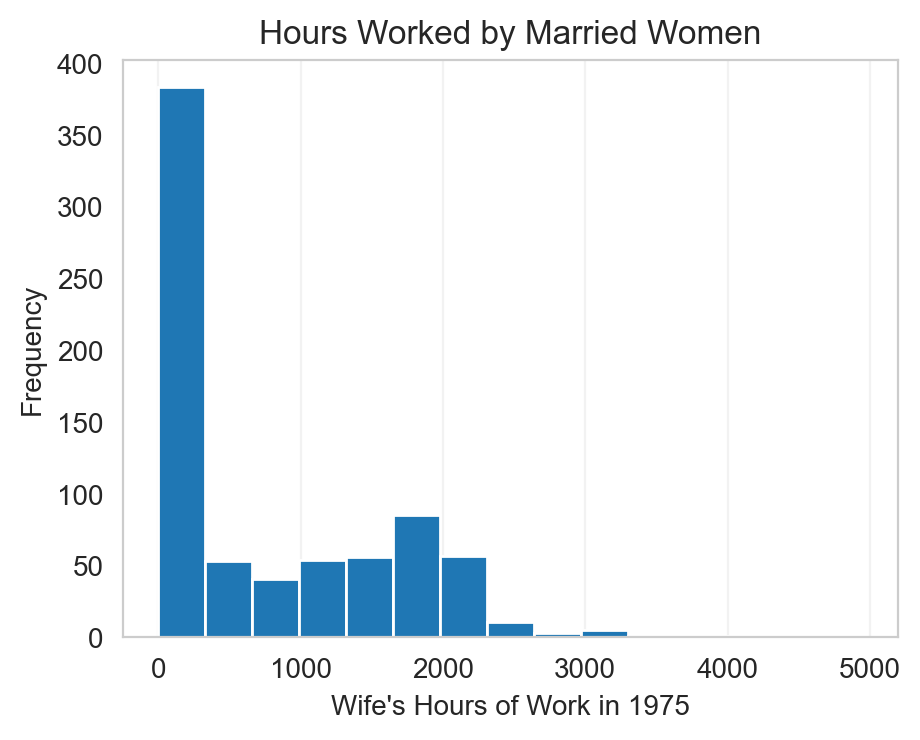

In [69]:
gr1=plt.hist(x=mroz.hours,bins='auto')
plt.grid(axis='y')
plt.xlabel('Wife\'s Hours of Work in 1975')
plt.ylabel('Frequency')
plt.title('Hours Worked by Married Women')
plt.show()

In [70]:
print(mroz[mroz['hours']>0][['hours','educ','exper','age','kidsl6']].describe().transpose())

        count         mean         std   min    25%     50%      75%     max
hours   428.0  1302.929907  776.274385  12.0  609.5  1365.5  1910.50  4950.0
educ    428.0    12.658879    2.285376   5.0   12.0    12.0    14.00    17.0
exper   428.0    13.037383    8.055923   0.0    7.0    12.0    18.00    38.0
age     428.0    41.971963    7.721084  30.0   35.0    42.0    47.25    60.0
kidsl6  428.0     0.140187    0.391923   0.0    0.0     0.0     0.00     2.0


In [71]:
print(mroz[mroz['hours']==0][['hours','educ','exper','age','kidsl6']]
      .describe().transpose())

        count       mean       std   min   25%   50%   75%   max
hours   325.0   0.000000  0.000000   0.0   0.0   0.0   0.0   0.0
educ    325.0  11.796923  2.181995   5.0  11.0  12.0  12.0  17.0
exper   325.0   7.461538  6.918567   0.0   3.0   5.0  10.0  45.0
age     325.0  43.283077  8.467796  30.0  36.0  44.0  50.0  60.0
kidsl6  325.0   0.366154  0.636900   0.0   0.0   0.0   1.0   3.0


In [72]:
resols=smf.ols(formula='hours~educ+exper+age+kidsl6',data=mroz).fit()
print(resols.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1335.3060    235.649      5.667      0.000     872.695    1797.918
educ          27.0857     12.240      2.213      0.027       3.057      51.114
exper         48.0398      3.642     13.191      0.000      40.890      55.189
age          -31.3078      3.961     -7.904      0.000     -39.084     -23.532
kidsl6      -447.8547     58.413     -7.667      0.000    -562.527    -333.183


In [73]:
mrozhg0=mroz[mroz['hours']>0]
resolshg0=smf.ols(formula='hours~educ+exper+age+kidsl6',data=mrozhg0).fit()
print(resolshg0.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1829.7459    292.536      6.255      0.000    1254.741    2404.750
educ         -16.4621     15.581     -1.057      0.291     -47.088      14.163
exper         33.9364      5.009      6.775      0.000      24.090      43.782
age          -17.1082      5.458     -3.135      0.002     -27.836      -6.381
kidsl6      -305.3090     96.449     -3.165      0.002    -494.888    -115.730


In [74]:
mroz=pd.read_csv(url+'mroz.csv')
y=mroz['hours']
mroz['cons']=1
x=mroz[['cons','educ','exper','age','kidsl6']]
censored=pd.Series(np.zeros((len(y),)))
censored[y==0]=-1
mrto=tobit.Tobit(y,x,cens=censored)
res=mrto.fit()
print(res.summary().tables[1])

Optimization terminated successfully.
         Current function value: 5.082528
         Iterations: 491
         Function evaluations: 794
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
cons        1349.8761    386.299      3.494      0.000     592.744    2107.008
educ          73.2910     20.475      3.580      0.000      33.162     113.420
exper         80.5353      6.288     12.808      0.000      68.211      92.859
age          -60.7678      6.888     -8.822      0.000     -74.268     -47.267
kidsl6      -918.9181    111.661     -8.230      0.000   -1137.769    -700.067
Log(Sigma)     7.0332      0.037    189.565      0.000       6.961       7.106


In [75]:
mroz=pd.read_csv(url+'mroz.csv')
print(mroz[['wage','educ','exper','kidsl6']].describe())
mroz['lwage']=np.where(mroz['wage']>0,np.log(mroz['wage']),np.nan)
print(mroz[['wage','educ','exper','kidsl6','lwage']])

             wage        educ      exper      kidsl6
count  753.000000  753.000000  753.00000  753.000000
mean     2.374565   12.286853   10.63081    0.237716
std      3.241829    2.280246    8.06913    0.523959
min      0.000000    5.000000    0.00000    0.000000
25%      0.000000   12.000000    4.00000    0.000000
50%      1.625000   12.000000    9.00000    0.000000
75%      3.787900   13.000000   15.00000    0.000000
max     25.000000   17.000000   45.00000    3.000000
       wage  educ  exper  kidsl6     lwage
0    3.3540    12     14       1  1.210154
1    1.3889    12      5       0  0.328512
2    4.5455    12     15       1  1.514138
3    1.0965    12      6       0  0.092123
4    4.5918    14      7       1  1.524272
..      ...   ...    ...     ...       ...
748  0.0000    13      5       0       NaN
749  0.0000    12     14       2       NaN
750  0.0000    12      4       0       NaN
751  0.0000    12     15       0       NaN
752  0.0000     9     12       0       NaN

[753 r

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [76]:
resols=smf.ols('lwage~educ+exper',data=mroz).fit()
print(resols.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4002      0.190     -2.102      0.036      -0.774      -0.026
educ           0.1095      0.014      7.728      0.000       0.082       0.137
exper          0.0157      0.004      3.900      0.000       0.008       0.024


In [77]:
mroz['kids']=np.where(mroz.kidsl6+mroz.kids618>0,1,0)
resp=probit('lfp~age+educ+kids+mtr',data=mroz).fit()
print(resp.summary())

Optimization terminated successfully.
         Current function value: 0.656237
         Iterations 5
                          Probit Regression Results                           
Dep. Variable:                    lfp   No. Observations:                  753
Model:                         Probit   Df Residuals:                      748
Method:                           MLE   Df Model:                            4
Date:                Wed, 18 Jun 2025   Pseudo R-squ.:                 0.04026
Time:                        09:29:25   Log-Likelihood:                -494.15
converged:                       True   LL-Null:                       -514.87
Covariance Type:            nonrobust   LLR p-value:                 2.164e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1923      0.721      1.655      0.098      -0.220       2.605
age           -0.0206      0.

In [78]:
mroz['what']=(resp.params.iloc[0]+
              resp.params.iloc[1]*mroz.age+
              resp.params.iloc[2]*mroz.educ+
              resp.params.iloc[3]*mroz.kids+
              resp.params.iloc[4]*mroz.mtr)
mroz['imr']=stats.norm.pdf(mroz.what)/stats.norm.cdf(mroz.what)
res=smf.ols('lwage~educ+exper+imr',data=mroz).fit()
print(res.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8105      0.494      1.639      0.102      -0.161       1.782
educ           0.0585      0.024      2.451      0.015       0.012       0.105
exper          0.0163      0.004      4.082      0.000       0.008       0.024
imr           -0.8664      0.327     -2.650      0.008      -1.509      -0.224


In [79]:
mroz['cons']=1
modheck=heckit.Heckit(mroz.lwage,mroz[['cons','educ','exper']],
                      mroz[['cons','age','educ','kids','mtr']])
resheck=modheck.fit(method='twostep')
print(resheck.summary())

                           Heckit Regression Results                            
Dep. Variable:                    lwage   R-squared:                      -0.507
Model:                           Heckit   Adj. R-squared:                 -0.514
Method:                Heckman Two-Step   F-statistics:                  -71.520
Date:                  Wed, 18 Jun 2025   Prob (F-statistic):              1.000
Time:                          09:29:25   Cov in 1st Stage:            nonrobust
No. Total Obs.:                     753   Cov in 2nd Stage:            nonrobust
No. Censored Obs.:                  325                                         
No. Uncensored Obs.:                428                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
cons           0.8105      0.611      1.327      0.185      -0.387       2.008
educ           0.0585      0.030  